In [1]:
from astropy.io import fits as fits
from astropy.io import ascii as asc
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize']=[12,8]


In [2]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
"""
Based on code written by alechat
"""

import os
import numpy as np
from subprocess import Popen, PIPE

def fits2npy(fits_file, idx_hdu):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//96
    data_list = []
    idx_list = range(0, 10000)
    for i in idx_list:
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        data_list.append(data[x:x+96,y:y+96])
    return np.asarray(data_list)

def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err

def generate_shape_txt(gal_file, psf_file,output_file, cmd_file='get_shape.cmd', gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    #print('Computing ellipticity for file: %s'%(gal_file))
    #print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s | tee %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s | tee %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

def get_target_shape(gal_file, output_file, idx=4):
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    images = fits.getdata(gal_file, idx)
    psfs = fits.getdata(gal_file, 3)
    fits.writeto(tmp_file, images)
    fits.writeto(tmp_psf_file, psfs)
    stdout, stderr = generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    return stdout, stderr

def get_ellipticity(file_name):
    ellip = []
    with open(file_name, 'r') as f:
        data = f.readlines()
    for l in data:
        ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
    return np.asarray(ellip)

def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err


def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

In [4]:
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
testset_file = 'image-shfl-0-multihdu.fits'
# Input the hdf5 file, here we load a network trained on Tikhonov
#net_file = '/data/DeepDeconv/model/DenseNet_vsc_rangeSNR20to100_nol2norm.hdf5'
net_path= '/home/fsureau/programs/DeepDeconv/'
#net_file = 'DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5'
#net_file = 'UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5'
net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100.hdf5'
net_root=net_file.replace('.hdf5','')


In [5]:
#im0=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",0)
#im1=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",1)
im2=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",2)
#plt.imshow(im0[0:192,0:192])
#plt.figure()
#plt.imshow(im1[0:192,0:192])
#plt.figure()
#plt.imshow(im2[0:192,0:192])
#Create target file and save it
hdu_target=fits.PrimaryHDU(im2)
hdul = fits.HDUList([hdu_target])
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
#hdul.writeto(write_path+'images/'+target_name,overwrite=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5b700116a0>,
 <matplotlib.colorbar.Colorbar at 0x7f5b6ff8f128>)

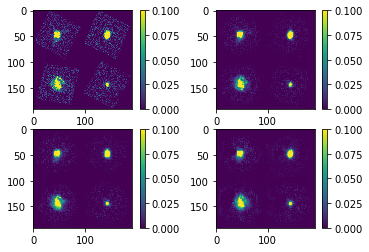

In [6]:
#Explore various results:
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
SNR=100
target=fits.getdata(write_path+'images/'+target_name)
unet4x4x4_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4=fits.getdata(unet4x4x4_name)
unet4x4x4_res_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4_res=fits.getdata(unet4x4x4_res_name)
deconvnet_name=write_path+"images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
deconvnet=fits.getdata(deconvnet_name)

plt.subplot(2,2,1),plt.imshow(target[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,2),plt.imshow(unet4x4x4[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,3),plt.imshow(unet4x4x4_res[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,4),plt.imshow(deconvnet[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()


## ELLIP ERROR

In [7]:
#Create Mosaic and save it
testset_file = 'image-shfl-0-multihdu.fits'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')

#perform target ellipticity measurements
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.txt')
#generate_shape_txt(write_path+'images/'+target_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')

In [8]:
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.txt')
save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')

SNR_list_sim=[20,40,60,80,100]
for SNR_sim in SNR_list_sim:
    mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
    ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.txt')
    #generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-i')



In [9]:
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.txt')

SNR_list_sim=[20,40,60,80,100]
for SNR_sim in SNR_list_sim:
    mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
    ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights_SNR{0}.txt'.format(SNR_sim))
    save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights_SNR{0}.fits'.format(SNR_sim))
    #generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')



In [7]:
import sharedmem as sm
AFFINITY_FLAG = False

def sharedmem_pool(used_cores):
    # see https://stackoverflow.com/questions/15639779
    global AFFINITY_FLAG
    if not AFFINITY_FLAG:
        AFFINITY_FLAG = True
        os.system("taskset -p 0xfff %d" % os.getpid())
    if used_cores is None:
        used_cores = sm.cpu_count()-2
    return sm.MapReduce(np=used_cores)

print(sm.cpu_count())

8


In [10]:
import glob,os,fnmatch
testset_file = 'image-shfl-0-multihdu.fits'
net_path= '/home/fsureau/programs/DeepDeconv/'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"

net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()

SNR_list_sim=[20,40,60,80,100]

# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
    
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.txt'.format(SNR_sim))
                save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')
                if not os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip {0}".format(mosaic_name) )
                    cmd_file = 'get_shape_{0}.cmd'.format(mosaic_name.replace('.fits','_ellipmes_targetweights'))
                    generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename,cmd_file=cmd_file, mosaic_size=100, save_weights=save_weights, weights_input='-i')
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
    


DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer4x5x6x7_relu_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer4x5x6x7_swish_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer5x5x5x5_relu_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_reshfl_SNR20to100.hdf5
not existing image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_reshfl_SNR20to100_testSNR20.fits
not existing image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_reshfl_SNR20to100_testSNR40.fits
not existing image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_reshfl_SNR20to100_testSNR60.fits
not existing image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_reshfl_SNR20to100_testSNR80.fits
not existing image-shfl-0-multihdu-DeconvNet2D_FCS_sc4

In [12]:
import glob,os,fnmatch
testset_file = 'image-shfl-0-multihdu.fits'
net_path= '/home/fsureau/programs/DeepDeconv/'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename_ref=write_path+'ellip/'+target_name.replace('.fits','ellipmes.txt')

net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()

SNR_list_sim=[20,40,60,80,100]

# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
    
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(1) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.txt'.format(SNR_sim))
                if os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip error {0}".format(mosaic_name) )
                        ell_err=compute_ellipticity_error(ellip_filename_ref, ellip_filename, plot_hist=False, max_idx=10000)
                        print("SNR=",SNR_sim,"MEAN_ERR=",np.mean(ell_err),"MEDIAN_ERR=",np.median(ell_err))
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
    


DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR20.fits
SNR= 20 MEAN_ERR= 0.12259844 MEDIAN_ERR= 0.11016871
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR40.fits
SNR= 40 MEAN_ERR= 0.07107752 MEDIAN_ERR= 0.0617998
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR60.fits
SNR= 60 MEAN_ERR= 0.051681712 MEDIAN_ERR= 0.044577904
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR80.fits
SNR= 80 MEAN_ERR= 0.04195649 MEDIAN_ERR= 0.035640925
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR

SNR= 100 MEAN_ERR= 0.03476269 MEDIAN_ERR= 0.028751118
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100.hdf5
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100_testSNR20.fits
SNR= 20 MEAN_ERR= 0.12041221 MEDIAN_ERR= 0.10863437
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100_testSNR40.fits
SNR= 40 MEAN_ERR= 0.06957211 MEDIAN_ERR= 0.060579676
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100_testSNR60.fits
SNR= 60 MEAN_ERR= 0.049957912 MEDIAN_ERR= 0.042771664
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100_testSNR80.fits
SNR= 80 MEAN_ERR= 0.04041956 MEDIAN_ERR= 0.03442768
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100_testSNR100.fits
SNR= 100 MEAN_ERR= 0.03440398 MEDIAN_ERR= 0.028564174
UNet2D_FCS_sc3_layer4x4

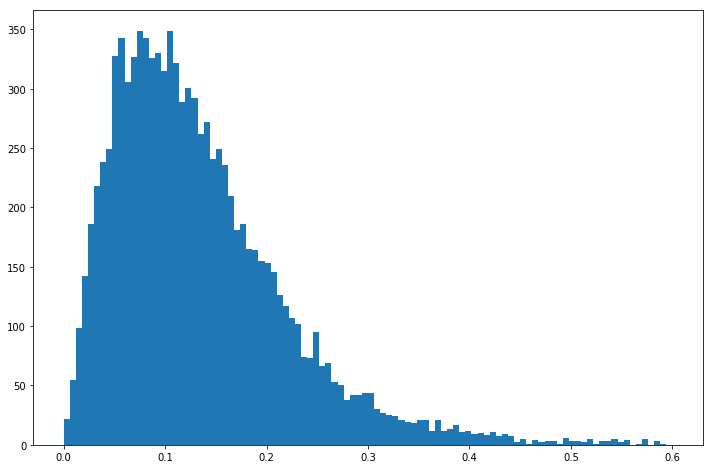

Total samples = 9941


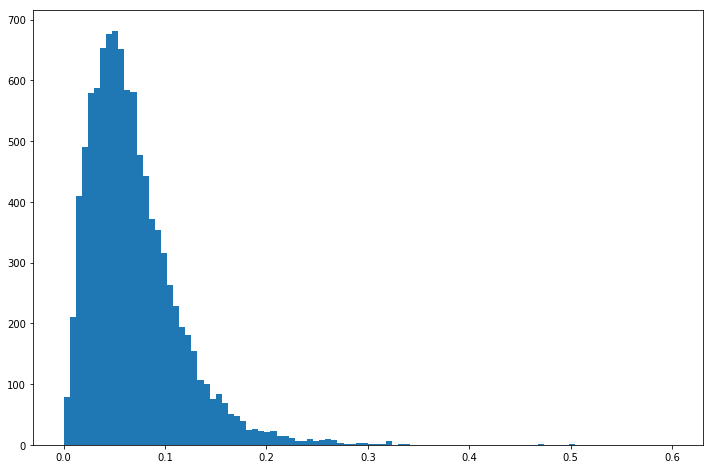

Total samples = 9979


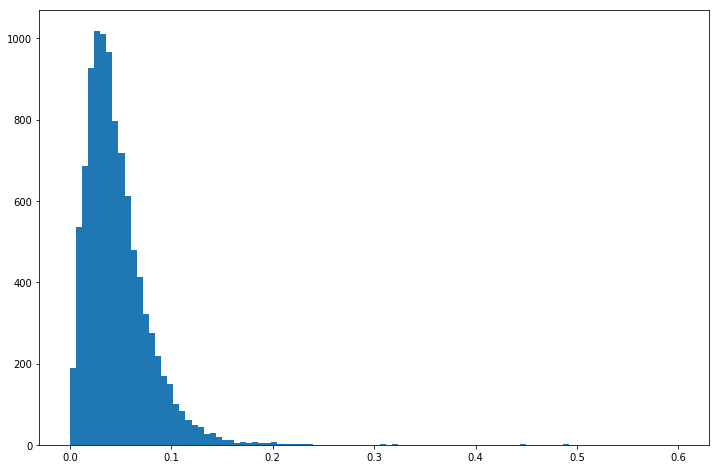

Total samples = 9983


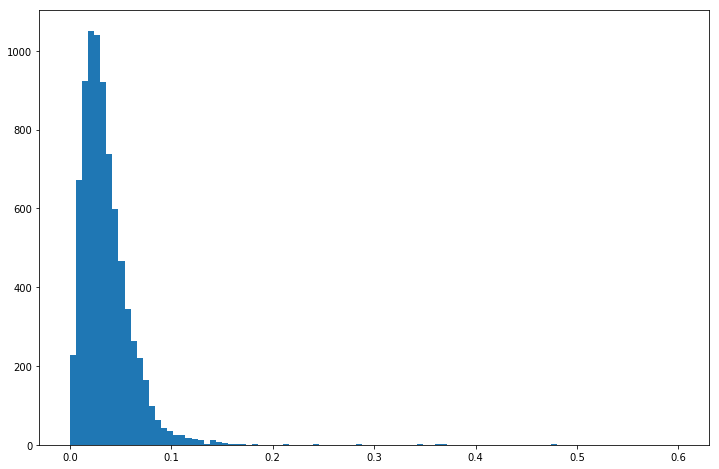

Total samples = 8000


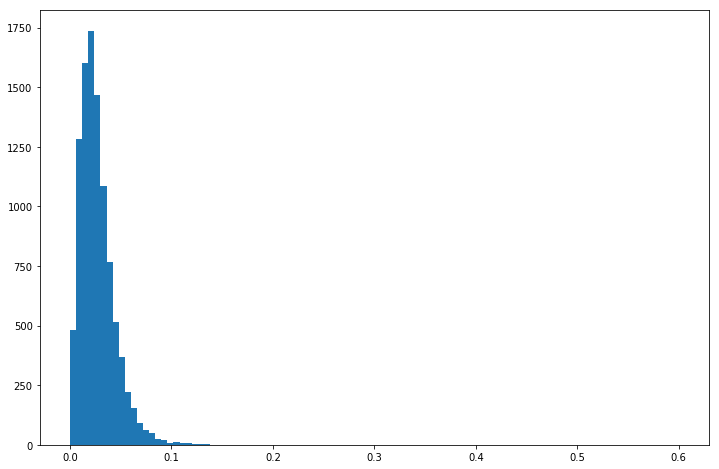

Total samples = 9981


In [32]:
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=write_path+'ellip/'+target_name.replace('.fits','ellipmes.txt')

SNR_list_sim=[20,40,60,80,100]
SNR_sim=20
ell_err_stats=np.zeros((2,5))
for kSNR,SNR_sim in enumerate(SNR_list_sim):
    mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
    ellip_filename_comp=write_path+'ellip/'+mosaic_name.replace('.fits','ellipmes_targetweights.txt')
    ell_err=compute_ellipticity_error(ellip_filename, ellip_filename_comp, plot_hist=True, max_idx=10000)
    ell_err_stats[0,kSNR]=np.mean(ell_err)
    ell_err_stats[1,kSNR]=np.median(ell_err)


[0.11662757 0.059725   0.04003417 0.03051143 0.02361635]


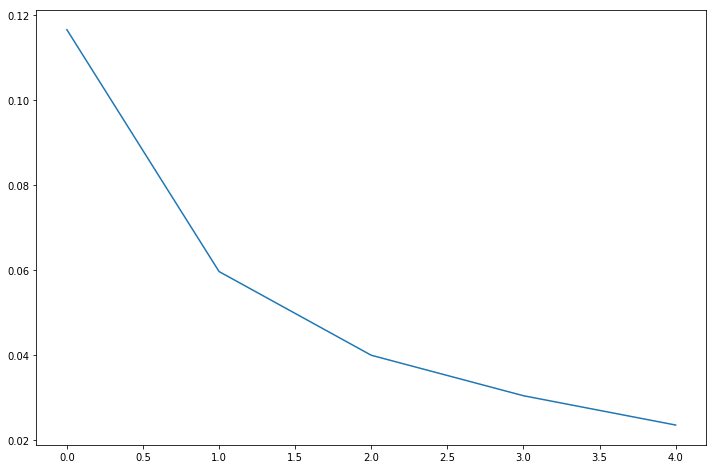

In [34]:
plt.plot(ell_err_stats[1])
print(ell_err_stats[1])

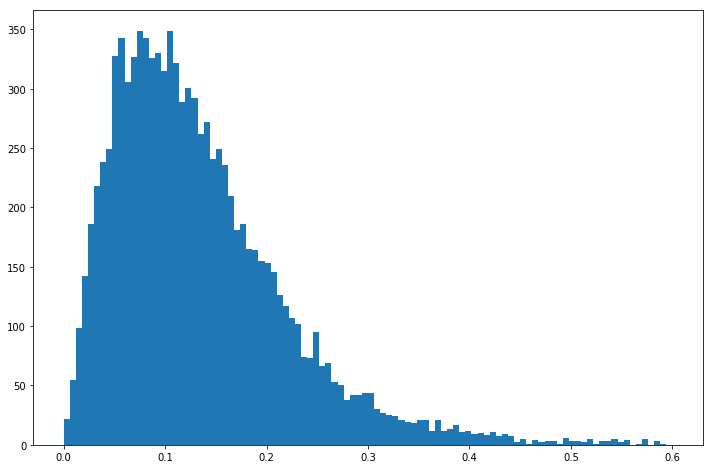

Total samples = 9941


In [13]:
ell_err=compute_ellipticity_error(ellip_filename, ellip_filename_comp, plot_hist=True, max_idx=10000)
ell_err=compute_ellipticity_error(ellip_filename, ellip_filename_comp, plot_hist=True, max_idx=10000)


In [ ]:
#net_file = 'DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5'
#net_file = 'UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5'
#net_file='DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5'
net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5'
testset_file = 'image-shfl-0-multihdu.fits'
target_name="images/target-shfl-0-multihdu.fits"

SNR_list_sim=[20,40,60,80,100]

# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
for SNR_sim in SNR_list_sim:
    mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
    err=compute_pixel_error(write_path+target_name, 0, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
    np.savetxt(write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt'),np.array(err))
    print("SNR=",SNR_SIM,"MEAN_ERR=",np.mean(err))


In [ ]:
#perform DNN ellipticity measurements
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','ellipmes_targetweights.txt')
#generate_shape_txt(write_path+mosaic_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-i')



In [94]:
err=compute_pixel_error(write_path+target_name, 0, write_path+write_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
np.savetxt(write_path+'stats/'+write_name.replace('.fits','_pixelerr.txt'),np.array(err))



In [90]:
len(err)

10000

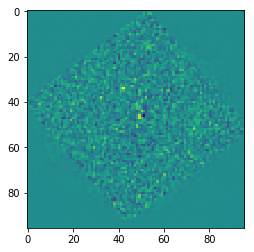

In [82]:
plt.imshow((X-ddt)[0:96,96:192])

TypeError: Invalid dimensions for image data

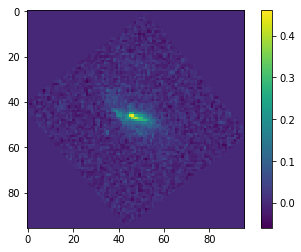

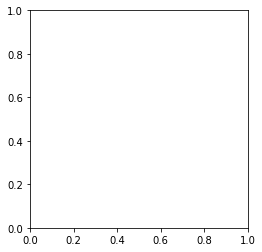

In [55]:
nb_gal_row = 100
X = fits.getdata(testset_path+testset_file,4)
Y = fits.getdata(write_path+write_name)
gal_dim=96
err = []
#for i in range(10000):
#    y = (gal_dim*i)%(nb_gal_row*gal_dim)
#    x = i//nb_gal_row * gal_dim
#    err.append((np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim]-Y[x:x+gal_dim,y:y+gal_dim][xslice, 
#                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))

plt.imshow(X[0:96,0:96]),plt.colorbar()
plt.figure()
plt.imshow(Y[0:96,0:96]),plt.colorbar()




(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fa8c0f75860>)

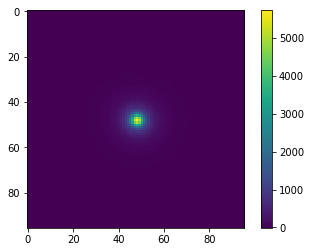

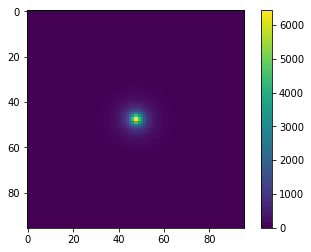

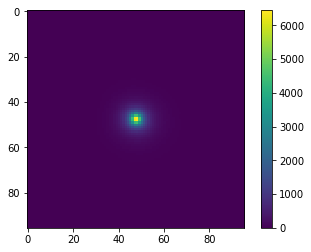

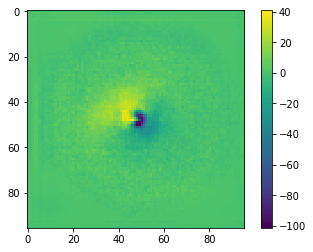

In [30]:
from matplotlib import pyplot as plt
plt.figure(),plt.imshow(np.sum(test_data[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(target_data[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(dnn_reconstruction[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(target_data[:,:,:,0]-dnn_reconstruction[:,:,:,0],axis=0)),plt.colorbar()#SNR=20,Oriented, [-70->80]

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f9b730b94a8>)

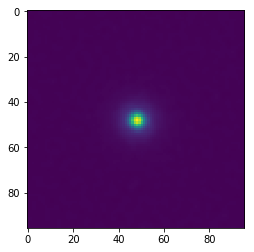

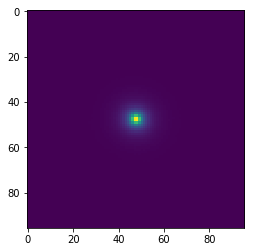

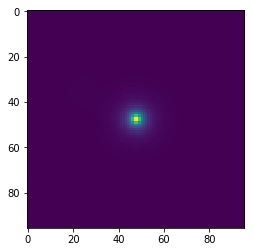

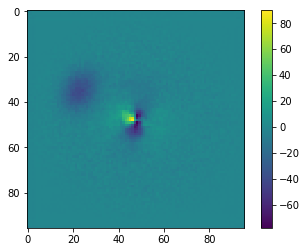

In [7]:
from matplotlib import pyplot as plt
plt.figure(),plt.imshow(np.sum(test_data[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(target_data[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(dnn_reconstruction[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(target_data[:,:,:,0]-dnn_reconstruction[:,:,:,0],axis=0)),plt.colorbar()#SNR=20,Oriented, [-70->80]



The DeepNet class also provides a method to extract intermediate features maps:

    get_layer_output(test_data, layer_idx)
    
layer_idx (int): idx of the layer whose features maps will be extracted.

Use dnn.model.summary() to retrieve the layers list.

In [31]:
dnn.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
separable_

In [ ]:
del dnn
k.clear_session()


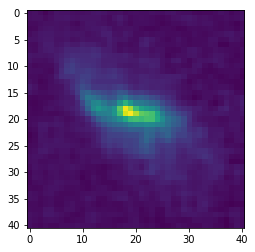

In [45]:
plt.imshow(dnn_reconstruction[0,slice(28,69,1),slice(28,69,1),0])


In [ ]:
# Suppose we want the last concatenation layer
idx = -4

# We print the name to check if you have the correct layer
print(dnn.model.layers[idx].name)

# We extract the features maps for the same data set as above.
# The layer has 48 neurons so we get an output of shape (10,96,96,48)
feat_maps = dnn.get_layer_output(test_data, layer_idx=idx)
print(feat_maps.shape)